# Italy Covid 19 vaccination data analysis and visualization

**Author**: Fabio Sona<br>
**Date**: 02 March 2021<br>
**Content**<br>
Data visualization and analyisis of Italy Covid 19 vaccination status based on opendata repository managed, on github, by "**Italian Government**" 

---


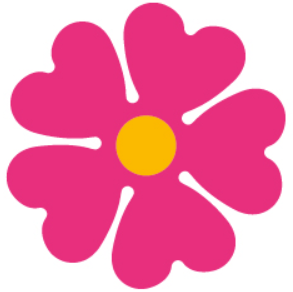

## Libraries Import 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import date
import numpy as np
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import scipy.special as sps 
import warnings 

ita_pop=60244639 #'Italian population'


## Data upload and cleaning

In [2]:
#%%
# Read region based data  from Italian Government repository 
dfVana=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/anagrafica-vaccini-summary-latest.csv")
dfVdel=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/consegne-vaccini-latest.csv",index_col=3, parse_dates=True)
dfVadm_loc=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/punti-somministrazione-latest.csv")
dfVloc_type=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/punti-somministrazione-tipologia.csv")
dfVadm=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv",index_col=0, parse_dates=True)
dfVadm_sum=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-summary-latest.csv",parse_dates=True)
dfVsum=pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/vaccini-summary-latest.csv")

In [3]:
dfVdel.index.max()

Timestamp('2021-03-22 00:00:00')

## Vaccine administration, delivery and utilisation progress

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


<function matplotlib.pyplot.show>

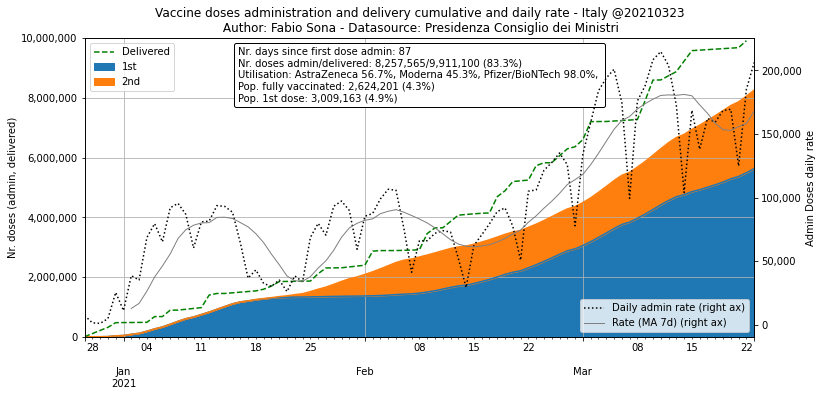

In [4]:
#
#PLOT VACCINE DOSE ADMINISTRATION VS DELIVERED CUMLATIVE PROGRESS AND DAILY RATE NATIONWIDE
#
#Prepare administered dataframe
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm=dfAdm[['prima_dose','seconda_dose']]
dfAdm=dfAdm.groupby(['data_somministrazione']).sum() 
dfDailyAdm=dfAdm['prima_dose']+dfAdm['seconda_dose'] #copy daily administration 
dfAdm=dfAdm.cumsum()
dfAdm=dfAdm.rename(columns={"prima_dose": "1st", "seconda_dose": "2nd"})

#Prepare delivered dataframe
dfDel=dfVdel.copy()
dfDel=dfDel.groupby(['data_consegna']).sum() 
dfDel=dfDel.cumsum()
dfDel=dfDel.fillna(method='ffill')
max_y=dfDel.iloc[-1].numero_dosi #scaling factor for y axis
max_y=(int(max_y/1e6)+1)*1e6
#Prepare dose utilisation dataframe
dfTD=dfVdel.groupby(['fornitore']).sum()
dfTA=dfVadm.groupby(['fornitore']).sum()
dfTA['tot_admin']=dfTA['prima_dose']+dfTA['seconda_dose']
dfU=pd.concat([dfTA,dfTD],axis=1)

dfU['ratio']=dfU['tot_admin']/dfU['numero_dosi']
util=dfU['tot_admin'].sum()/dfU['numero_dosi'].sum()
util=int(util*100*10)/10
ut_str=''
for s in dfU.index:
  tu= int(dfU.loc[s].ratio*100*10)/10 
  ut_str=ut_str+s+' '+ str(tu)+'%, '

#Get last date of relevant data 
today=dfVadm.index.max()  
d=today.strftime("%Y%m%d")

MA=7 #moving average param
len=dfAdm.shape[0]

#Calc parameters to display in the box
totadmin=(dfAdm.iloc[-1]['1st']+dfAdm.iloc[-1]['2nd'])
prc_atone=int(totadmin/ita_pop*100*10)/10
full_vacc=dfAdm.iloc[-1]['2nd']
strfull_vacc='{:,.0f}'.format(full_vacc)
prc_full=int(dfAdm.iloc[-1]['2nd']/ita_pop*100*10)/10
oned_vacc=totadmin-2*full_vacc
stroned_vacc='{:,.0f}'.format(oned_vacc)
prc_oned=int(oned_vacc/ita_pop*100*10)/10
max_del='{:,.0f}'.format(dfDel.iloc[-1].numero_dosi)
max_adm='{:,.0f}'.format(totadmin)
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format

#Plot
fig, ax =plt.subplots(figsize=(12,5.5))
dfAdm.plot.area(grid=True, ax=ax)
dfDel['numero_dosi'].plot(kind='line', linestyle="--",color='green',label='Delivered',ax=ax)
ax2=ax.twinx()
dfDailyAdm.plot(kind='line', linestyle=":",color='black',label='Daily admin rate (right ax)',ax=ax2)
dfDailyAdm.rolling(window=MA).mean().plot(kind='line',linestyle="-",lw=1,color='grey',label='Rate (MA 7d) (right ax)',ax=ax2)
ax.set_xlabel('')
ax.set_ylabel('Nr. doses (admin, delivered)')
ax2.set_ylabel('Admin Doses daily rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylim([0,max_y]) 
ax.grid()
at = AnchoredText('Nr. days since first dose admin: '+str(len)+ 
                  '\nNr. doses admin/delivered: ' + max_adm +'/'+max_del +' ('+str(util)+'%)' +
                  '\nUtilisation: '+ut_str+
                  '\nPop. fully vaccinated: '+str(strfull_vacc)+' ('+str(prc_full)+'%)'+
                  '\nPop. 1st dose: '+str(stroned_vacc)+' ('+str(prc_oned)+'%)',
                  prop=dict(size=10,color='black'), frameon=True,loc='upper center')
at.patch.set_boxstyle("round,pad=0,rounding_size=0.2")
ax.add_artist(at)
ax.legend()
ax2.legend(loc='lower right')
plt.title('Vaccine doses administration and delivery cumulative and daily rate - Italy @'+d+
          '\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=12)
plt.savefig('V'+d+'_ItalyDosesPhaseProgress.png',dpi=300)
plt.show

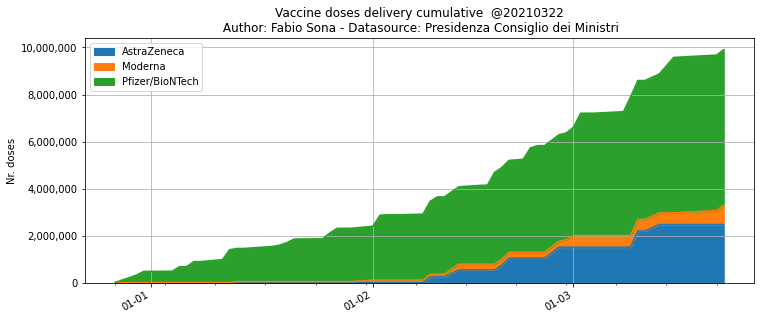

In [5]:
#
#PLOT VACCINE DOSE DELIVERY CUMULATIVE PROGRESS PER SUPPLIER
#
dfDel=pd.pivot_table(dfVdel, values = 'numero_dosi',aggfunc=np.sum, index=dfVdel.index, columns = 'fornitore').reset_index()
dfDel=dfDel.rename(columns={"fornitore": "Supplier"})
dfDel.set_index('data_consegna',inplace=True)

today=dfDel.index[-1]  
d1=today.strftime("%Y%m%d")

dfDel=dfDel.cumsum()
dfDel=dfDel.fillna(method='ffill')

fig, ax =plt.subplots(figsize=(12,5))
dfDel.plot.area(grid=True, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Nr. doses')
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm forma
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
#ax.xaxis.set_minor_formatter(ticker.NullFormatter())  
plt.legend()
plt.title('Vaccine doses delivery cumulative  @'+d1+
          '\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=12) 
plt.savefig('V'+d1+'_ItalyDosesDeliveryProgress.png',dpi=300)
plt.show()

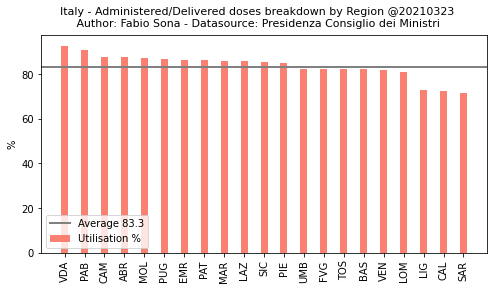

In [6]:
#Utilisation per region

dfTemp=dfVsum.copy()
#today=dfTemp.iat[1,4] #Get last date of relevant data 
# d=today.strftime("%Y%m%d")
#d=str(today)



width = 0.35
dfTemp=dfTemp.sort_values(by=['percentuale_somministrazione'],ascending=False)
labels=dfTemp['area']
data=dfTemp['percentuale_somministrazione']
ave_prc=dfTemp['dosi_somministrate'].sum()/dfTemp['dosi_consegnate'].sum()*100

fig,ax = plt.subplots(figsize=(8,4))
ax.bar(labels,data, width,label='Utilisation %',color='salmon',)
ax.axhline(y=ave_prc, color='grey',lw=2, linestyle='-', label='Average ' + str(int(ave_prc*10)/10))
ax.set_xticklabels(labels, rotation = 90) 
ax.set_ylabel('%')
plt.legend(loc="lower left")
fig.suptitle('Italy - Administered/Delivered doses breakdown by Region @'+d+'\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=11) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_ItalyDosesUtilisationRegion.png',dpi=300)
plt.show()


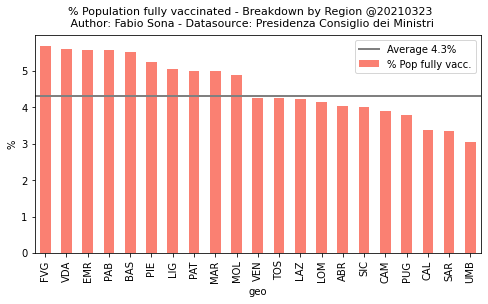

In [7]:
population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli-Venezia Giulia','Provincia Autonoma Trento','Provincia Autonoma Bolzano / Bozen','Umbria','Basilicata','Molise',"Valle d'Aosta / Vallée d'Aoste"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,556934,302265,125501],
        'geoid': ['ITA','LOM', 'LAZ','CAM','SIC','VEN','EMR','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','PAT','PAB','UMB','BAS','MOL','VDA']
        }

dfAb = pd.DataFrame (population, columns = ['geo','ab','geoid'])
dfAb.set_index("geo", inplace=True)

dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm=pd.pivot_table(dfAdm, values = 'seconda_dose',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
dfAdm=dfAdm.cumsum()
dfAdm=dfAdm.fillna(method='ffill')
dfAdm=dfAdm.iloc[-1]
# today=dfAdm.index[-1]  
# d=today.strftime("%Y%m%d")

dfAb=dfAb.iloc[1:,:]
dfAb=dfAb.sort_values('geo',ascending=True)
dfAb['2nd']=dfAdm
dfAb['vacc_ratio']=dfAdm/dfAb.ab*100
dfAb=dfAb.sort_values('vacc_ratio',ascending=False)
labels=dfAb.geoid
width=0.35
fig,ax = plt.subplots(figsize=(8,4))
dfAb['vacc_ratio'].plot(kind="bar",label='% Pop fully vacc.',color='salmon',ax=ax)
ax.axhline(y=prc_full, color='grey',lw=2, linestyle='-', label='Average ' + str(int(prc_full*10)/10)+'%')
ax.set_xticklabels(labels, rotation = 90) 
ax.set_ylabel('%')
plt.legend(loc="upper right")
fig.suptitle('% Population fully vaccinated - Breakdown by Region @'+d+'\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=11) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_PopVaccinatedRegion.png',dpi=300)
plt.show()

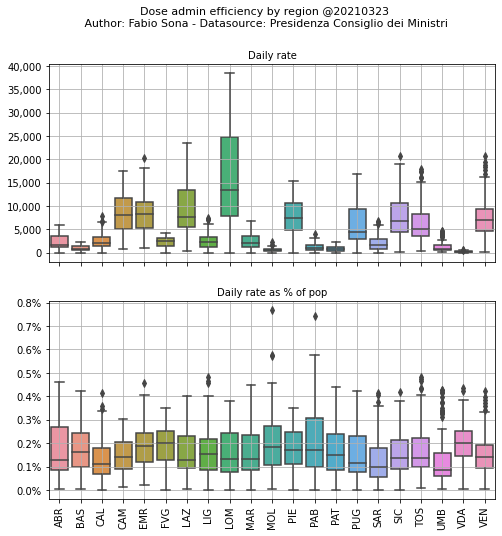

In [8]:
#Speed statistics YTD

population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli-Venezia Giulia','Provincia Autonoma Trento','Provincia Autonoma Bolzano / Bozen','Umbria','Basilicata','Molise',"Valle d'Aosta / Vallée d'Aoste"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,556934,302265,125501],
        'geoid': ['ITA','LOM', 'LAZ','CAM','SIC','VEN','EMR','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','PAT','PAB','UMB','BAS','MOL','VDA']
        }



today=dfAdm.index[-1]  
# d=today.strftime("%Y%m%d")


dfAb = pd.DataFrame (population, columns = ['geo','ab','geoid'])
dfAb.set_index("geo", inplace=True)
dfAb=dfAb.iloc[1:,:]
dfAb=dfAb.sort_values('geo',ascending=True)

dfAdm=dfVadm.copy()
dfAdm['tot_dosi']= dfAdm['prima_dose'] + dfAdm['seconda_dose']
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
#dfAdm.head()
df=dfAdm

fig,(ax,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,8),sharex=True)
sns.boxplot(data=dfAdm,ax=ax)
ax.grid()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(dfAb.geoid,rotation = 90)
ax.set_xlabel('')
ax.set_title('Daily rate',size=10)


#Calculate admin / population
dfAbT=dfAb.T
dfAdm=dfAdm.divide(dfAbT.iloc[0])

sns.boxplot(data=dfAdm,ax=ax2)
ax2.grid()
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_xticklabels(dfAb.geoid,rotation = 90)
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.1%}'.format))
ax2.set_xlabel('')
ax2.set_title('Daily rate as % of pop',size=10)
fig.suptitle('Dose admin efficiency by region @'+d+'\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=11) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_DoseAdminEfficiencyRegion.png',dpi=300)
plt.show()


In [9]:
dfVdel.index.max()

Timestamp('2021-03-22 00:00:00')

In [10]:
# print(dfVadm['2021-03-01':])
# # dfAdm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


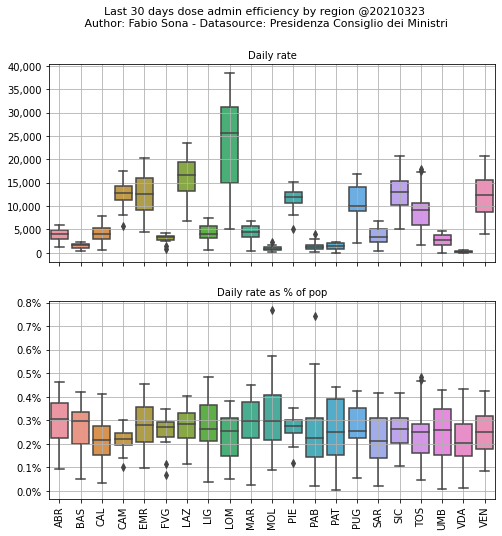

In [11]:
#Speed statistics Last "LAG"" days

population = {'geo': ['Italy','Lombardia', 'Lazio','Campania','Sicilia','Veneto','Emilia-Romagna','Piemonte','Puglia','Toscana','Calabria','Sardegna','Liguria','Marche','Abruzzo','Friuli-Venezia Giulia','Provincia Autonoma Trento','Provincia Autonoma Bolzano / Bozen','Umbria','Basilicata','Molise',"Valle d'Aosta / Vallée d'Aoste"],
        'ab': [60244639,10103969,5865544,5785861,4968410,4907704,4467118,4341375,4008296,3722729,1924701,1630474,1543127,1518400,1305770,1211357,542739,532080,1074819,556934,302265,125501],
        'geoid': ['ITA','LOM', 'LAZ','CAM','SIC','VEN','EMR','PIE','PUG','TOS','CAL','SAR','LIG','MAR','ABR','FVG','PAT','PAB','UMB','BAS','MOL','VDA']
        }


today=dfVadm.last_valid_index()
d=today.strftime("%Y%m%d")
lag=30

dfAb = pd.DataFrame (population, columns = ['geo','ab','geoid'])
dfAb.set_index("geo", inplace=True)
dfAb=dfAb.iloc[1:,:]
dfAb=dfAb.sort_values('geo',ascending=True)

dfAdm=dfVadm[today-pd.DateOffset(lag, 'D'):]

dfAdm['tot_dosi']= dfAdm['prima_dose'] + dfAdm['seconda_dose']
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
#dfAdm.head()
df=dfAdm

fig,(ax,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(8,8),sharex=True)
sns.boxplot(data=dfAdm,ax=ax)
ax.grid()
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xticklabels(dfAb.geoid,rotation = 90)
ax.set_xlabel('')
ax.set_title('Daily rate',size=10)


#Calculate admin / population
dfAbT=dfAb.T
dfAdm=dfAdm.divide(dfAbT.iloc[0])

sns.boxplot(data=dfAdm,ax=ax2)
ax2.grid()
#ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.set_xticklabels(dfAb.geoid,rotation = 90)
ax2.yaxis.set_major_formatter(FuncFormatter('{0:.1%}'.format))
ax2.set_xlabel('')
ax2.set_title('Daily rate as % of pop',size=10)
fig.suptitle('Last '+str(lag)+' days dose admin efficiency by region @'+d+'\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=11) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_30DaysDoseAdminEfficiencyRegion.png',dpi=300)
plt.show()


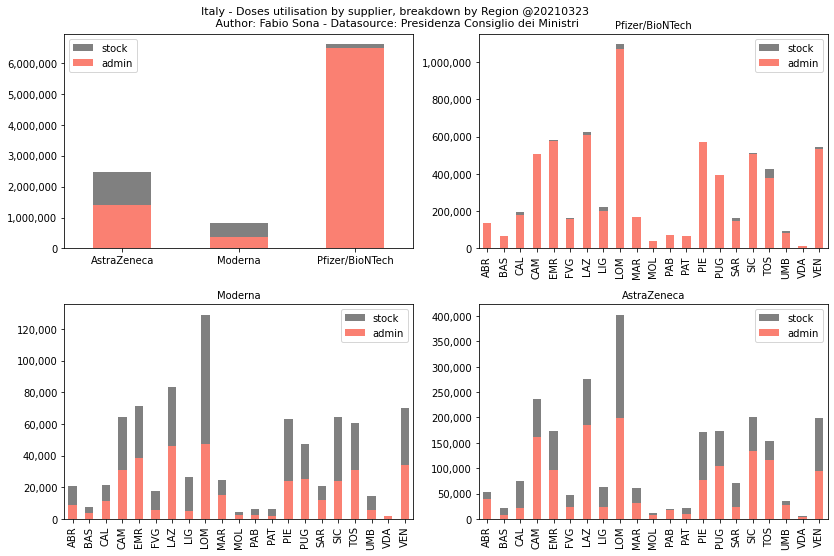

<function matplotlib.pyplot.show>

In [12]:
#PLOT VACCINE DOSES UTILISATION  BY SUPPLIER and REGION

fig, axes =plt.subplots(nrows=2,ncols=2,figsize=(12,8))

fig.tight_layout(pad=3.5)
dfAdm=dfVadm.copy()
dfAdm['tot_admin']=dfAdm['prima_dose']+dfAdm['seconda_dose']
suppliers=dfAdm['fornitore'].unique()
dfDel=dfVdel.copy()
dfAdm=dfAdm.groupby(['fornitore'])['tot_admin'].sum()
dfDel=dfDel.groupby(['fornitore'])['numero_dosi'].sum()
dfAdm.head()

dfDel.plot(kind='bar',color='grey',ax=axes[0,0],label='stock')
dfAdm.plot(kind='bar',color='salmon',ax=axes[0,0],label='admin')

axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0,0].set_xlabel("")
axes[0,0].tick_params(rotation=0)
axes[0,0].legend()

dfAdm=dfVadm.copy()
dfAdm['tot_admin']=dfAdm['prima_dose']+dfAdm['seconda_dose']
suppliers=dfAdm['fornitore'].unique()
dfDel=dfVdel.copy()

r=0
col=[1,0,1]
idx=0
for s in suppliers:
  c=col[idx]
  totA=dfAdm[dfAdm['fornitore']==s].groupby(['area'])['tot_admin'].sum()
  totD=dfDel[dfDel['fornitore']==s].groupby(['area'])['numero_dosi'].sum()
  totD.plot(kind='bar',color='grey',ax=axes[r,c],label='stock')
  totA.plot(kind='bar',color='salmon',ax=axes[r,c],label='admin')
  axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
  axes[r,c].legend()
  axes[r,c].set_xlabel("")
  axes[r,c].set_title(s,size=10)
  r=1
  idx=idx+1
  
fig.suptitle('Italy - Doses utilisation by supplier, breakdown by Region @'+d+'\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',size=11,x=0.45) #+" Source:Presidenza del Consiglio dei Ministri",y=1.0, x=0.5) 
plt.savefig('V'+d+'_ItalyDosesUtilisationSupplierRegion.png')
plt.show()
plt.show


## Vaccine administration progress by region

20210323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


<function matplotlib.pyplot.show>

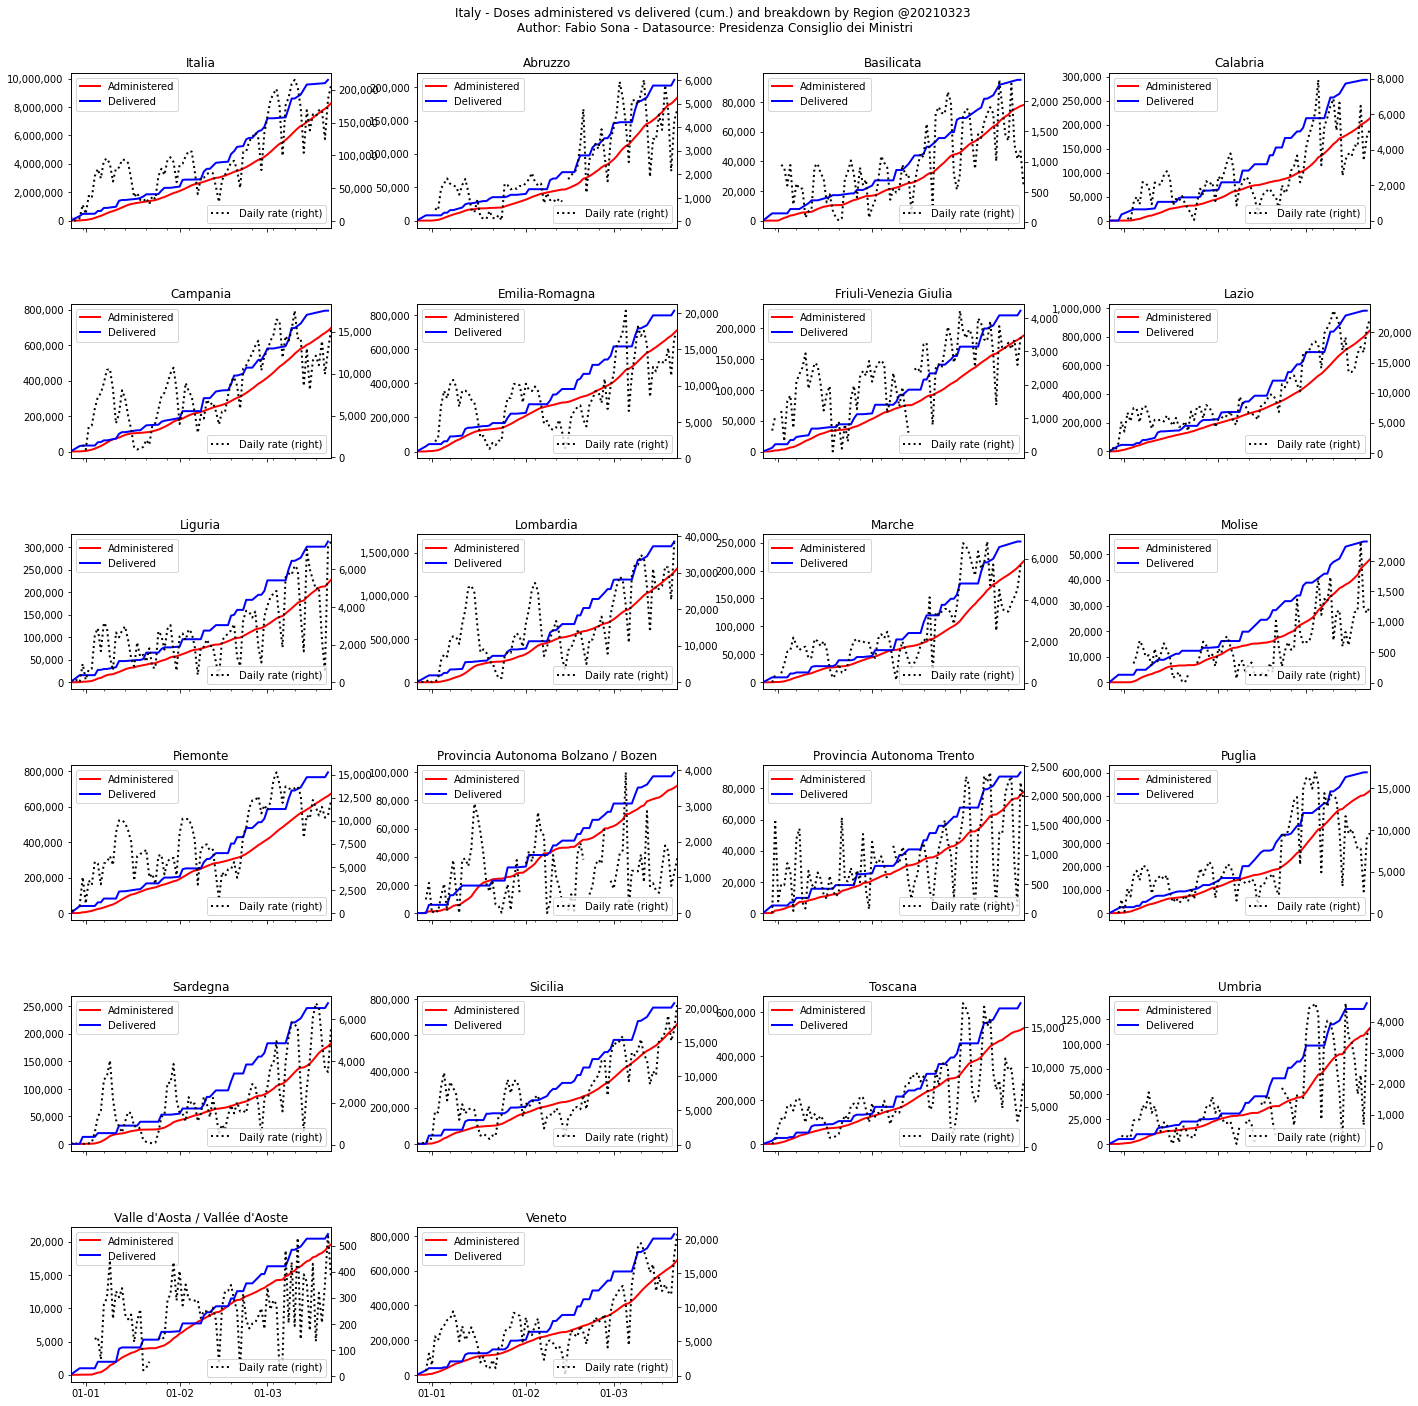

In [13]:
#Prepare data to plot administered doses vs. delivered on a daily basis
#Delivered
today=dfVadm.index[-1] #Get last date of relevant data 
d=today.strftime("%Y%m%d")
print(d)
dfDel=dfVdel.copy()
dfDel=dfDel.sort_values('nome_area',ascending=True)
dfDel['Week_Number'] = dfDel.index.weekofyear
dfDel['Year'] = dfDel.index.year
dfDel=pd.pivot_table(dfDel, values = 'numero_dosi',index = ['data_consegna'],aggfunc=np.sum, columns = 'nome_area')#.reset_index()
dfDel=dfDel.cumsum().reset_index()
dfDel=dfDel.fillna(method='ffill')
dfDel.set_index('data_consegna',inplace=True)
dfDel["sum"] = dfDel.sum(axis=1)
#dfDel.head(100)

#Administered
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
dfDaily=dfAdm.copy()
dfDaily["sum"] = dfDaily.sum(axis=1)
dfAdm=dfAdm.cumsum().reset_index()
dfAdm=dfAdm.fillna(method='ffill')
dfAdm.set_index('data_somministrazione',inplace=True)
dfAdm["sum"] = dfAdm.sum(axis=1)


#Main loop
nrows=6 
ncols=4
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(20,20)) #
fig.tight_layout(pad=5.5)
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
idx=0
for r in range(nrows):
  for c in range(ncols):
    if r==0 and c==0: #First box for Nationwide data 
        dfAdm[dfAdm.columns[21]].plot(kind='line', linestyle="-",lw=2,color='red',grid=False,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
        dfDel[dfDel.columns[21]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
        ax2=axes[r,c].twinx()
        dfDaily[dfDaily.columns[21]].plot(kind='line', linestyle=":",lw=2,color='black',grid=False,rot=0,legend=False,label='Daily rate (right)',ax=ax2,sharex=False)       
        axes[r,c].set_title('Italia')
        # axes[r,c].set_ylabel('Nr. doses (admin, delivered)')
        # ax2.set_ylabel('Daily rate')
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].set_xlabel('')
        axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
        axes[r,c].xaxis.set_major_formatter(date_form)
        axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
        axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
        axes[r,c].legend()       
        ax2.legend(loc='lower right')
        #idx=idx+1    
    
    elif  idx<=20 : #then plot regions individually
      
        dfAdm[dfAdm.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='red',grid=False,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
        dfDel[dfDel.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
        ax2=axes[r,c].twinx()
        dfDaily[dfDaily.columns[idx]].plot(kind='line', linestyle=":",lw=2,color='black',grid=False,rot=0,legend=False,label='Daily rate (right)',ax=ax2,sharex=False)
        # ax2.set_ylabel('Daily rate')
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].set_title(dfAdm.columns[idx])
        # axes[r,c].set_ylabel('Nr. doses (admin, delivered)')
        axes[r,c].set_xlabel('')
        axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
        axes[r,c].xaxis.set_major_formatter(date_form)
        axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
        axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
        axes[r,c].legend()
        ax2.legend(loc='lower right')
        idx=idx+1
    else:
      break
axes[nrows-1,ncols-1].set_visible(False)
axes[nrows-1,ncols-2].set_visible(False)

fig.suptitle('Italy - Doses administered vs delivered (cum.) and breakdown by Region @'+d+
          '\n Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',y=1.005, x=0.5) 
plt.savefig('V'+d+'_ItalyDosesStatusRegion.png',dpi=300)
plt.show

20210323


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


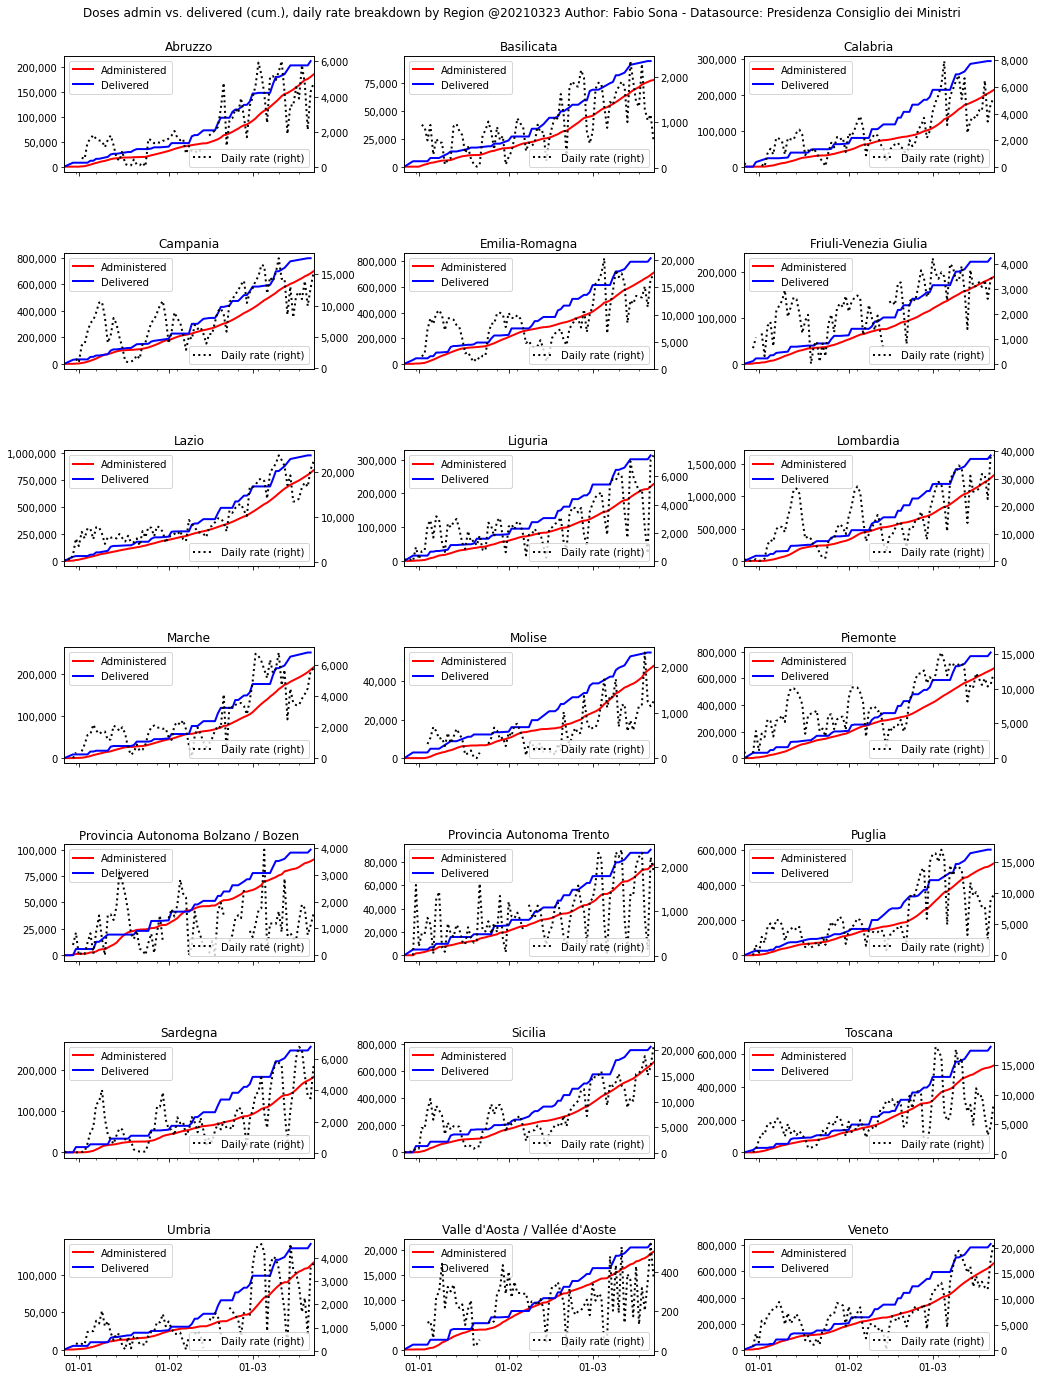

In [14]:
#Prepare data to plot administered doses vs. delivered on a daily basis
#Delivered
today=dfVadm.index[-1] #Get last date of relevant data 
d=today.strftime("%Y%m%d")
print(d)
dfDel=dfVdel.copy()
dfDel=dfDel.sort_values('nome_area',ascending=True)
dfDel['Week_Number'] = dfDel.index.weekofyear
dfDel['Year'] = dfDel.index.year
dfDel=pd.pivot_table(dfDel, values = 'numero_dosi',index = ['data_consegna'],aggfunc=np.sum, columns = 'nome_area')#.reset_index()
dfDel=dfDel.cumsum().reset_index()
dfDel=dfDel.fillna(method='ffill')
dfDel.set_index('data_consegna',inplace=True)
dfDel["sum"] = dfDel.sum(axis=1)
#dfDel.head(100)

#Administered
dfAdm=dfVadm.copy()
dfAdm=dfAdm.sort_values('nome_area',ascending=True)
dfAdm['Week_Number'] = dfAdm.index.weekofyear
dfAdm['Year'] = dfAdm.index.year
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['data_somministrazione'],aggfunc=np.sum, columns = 'nome_area')
dfDaily=dfAdm.copy()
dfDaily["sum"] = dfDaily.sum(axis=1)
dfAdm=dfAdm.cumsum().reset_index()
dfAdm=dfAdm.fillna(method='ffill')
dfAdm.set_index('data_somministrazione',inplace=True)
dfAdm["sum"] = dfAdm.sum(axis=1)


#Main loop
nrows=7 
ncols=3
fig, axes = plt.subplots(nrows, ncols,sharex=False,figsize=(15,20)) #
fig.tight_layout(pad=6)
date_form = mdates.DateFormatter("%d-%m") #Format date into dd-mm format
idx=0
for r in range(nrows):
  for c in range(ncols):
    # if r==0 and c==0: #First box for Nationwide data 
    #     dfAdm[dfAdm.columns[21]].plot(kind='line', linestyle="-",lw=2,color='red',grid=False,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
    #     dfDel[dfDel.columns[21]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
    #     ax2=axes[r,c].twinx()
    #     dfDaily[dfDaily.columns[21]].plot(kind='line', linestyle=":",lw=2,color='black',grid=False,rot=0,legend=False,label='Daily rate (right)',ax=ax2,sharex=False)       
    #     axes[r,c].set_title('Italia')
    #     # axes[r,c].set_ylabel('Nr. doses (admin, delivered)')
    #     # ax2.set_ylabel('Daily rate')
    #     ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    #     axes[r,c].set_xlabel('')
    #     axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    #     axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
    #     axes[r,c].xaxis.set_major_formatter(date_form)
    #     axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
    #     axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
    #     axes[r,c].legend()       
    #     ax2.legend(loc='lower right')
    #     #idx=idx+1    
    
    # elif  idx<=20 : #then plot regions individually
      
        dfAdm[dfAdm.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='red',grid=False,rot=0,legend=False,label='Administered',ax=axes[r,c],sharex=False)
        dfDel[dfDel.columns[idx]].plot(kind='line', linestyle="-",lw=2,color='blue',grid=False,rot=0,legend=False,label='Delivered',ax=axes[r,c],sharex=False)
        ax2=axes[r,c].twinx()
        dfDaily[dfDaily.columns[idx]].plot(kind='line', linestyle=":",lw=2,color='black',grid=False,rot=0,legend=False,label='Daily rate (right)',ax=ax2,sharex=False)
        # ax2.set_ylabel('Daily rate')
        ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].set_title(dfAdm.columns[idx])
        # axes[r,c].set_ylabel('Nr. doses (admin, delivered)')
        axes[r,c].set_xlabel('')
        axes[r,c].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[r,c].xaxis.set_major_locator(mdates.MonthLocator())
        axes[r,c].xaxis.set_major_formatter(date_form)
        axes[r,c].xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=SU))
        axes[r,c].xaxis.set_minor_formatter(ticker.NullFormatter())   
        axes[r,c].legend()
        ax2.legend(loc='lower right')
        idx=idx+1
#     else:
#       break
# # axes[nrows-1,ncols-1].set_visible(False)
# axes[nrows-1,ncols-2].set_visible(False)

fig.suptitle('Doses admin vs. delivered (cum.), daily rate breakdown by Region @'+d+
          ' Author: Fabio Sona - Datasource: Presidenza Consiglio dei Ministri',y=0.990, x=0.5)

plt.savefig('V'+d+'_ItalyDosesStatusRegion.png',dpi=300)
plt.show()

## Vaccine administration by category and age group

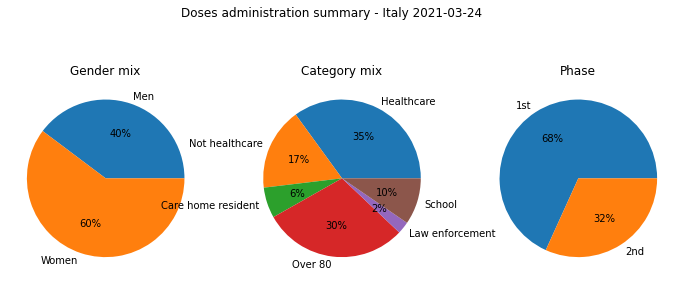

In [15]:
#Plot pie charts by Gender, Category and Phase
dfTemp=dfVana.copy()
dfTemp.loc['Column_Total']= dfTemp.sum(numeric_only=True, axis=0)
rows=dfTemp.shape[0]-1
d=dfVana.iat[0,12] #Get Date of update
#print(dfTemp)
#Set up picture frame
fig, axs = plt.subplots(1,3,figsize=(12,5))
warnings.filterwarnings("ignore") # specify to ignore warning messages

#Plot Gender mix
data=dfTemp.iloc[rows:,2:4]
labels = 'Men', 'Women'
axs[0].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[0].set_title('Gender mix')

#Plot Cat mix
data=dfTemp.iloc[rows:,4:10]
labels = 'Healthcare', 'Not healthcare', 'Care home resident', 'Over 80','Law enforcement','School'
axs[1].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[1].set_title('Category mix')

#Plot 1st, 2nd mix
data=dfTemp.iloc[rows:,10:12]
labels = '1st', '2nd'
axs[2].pie(data,labels=labels, autopct='%1.0f%%') #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[2].set_title('Phase')

fig.suptitle('Doses administration summary - Italy '+d)
plt.savefig('V'+d+'_ItalyDosesSummary.png')
plt.show()


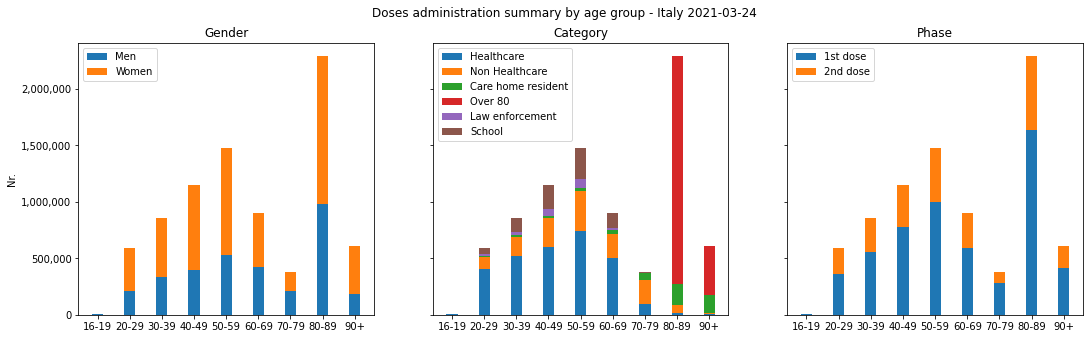

In [16]:
#Plot bar charts by Gender, Category and Phase and breakdown by age group

#Set up picture frame
fig, axs = plt.subplots(1,3,figsize=(18,5),sharey=True)
width = 0.35       # the width of the bars: can also be len(x) sequence
labels = dfVana['fascia_anagrafica']

#By Gender
men = dfVana['sesso_maschile']
women = dfVana['sesso_femminile']

axs[0].bar(labels, men, width,label='Men')
axs[0].bar(labels, women, width, bottom=men,label='Women')
axs[0].set_ylabel('Nr.')
axs[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[0].set_title('Gender')
axs[0].legend()

#By Category
dfCat=dfVana.iloc[:,4:10]
ssn = dfVana['categoria_operatori_sanitari_sociosanitari']
non_san = dfVana['categoria_personale_non_sanitario']
rsa = dfVana['categoria_ospiti_rsa']
over80 = dfVana['categoria_over80']
ffaa = dfVana['categoria_forze_armate']
scuola = dfVana['categoria_personale_scolastico']

 
# Values of each group
bars1 = [12, 28, 1, 8, 22]
bars2 = [28, 7, 16, 4, 10]
bars3 = [25, 3, 23, 25, 17]
 
# Heights of bars1 + bars2
#bars1 = np.add(ssn).tolist()
bars2 = np.add(ssn,non_san).tolist()
bars3 = np.add(bars2,rsa).tolist()
bars4 = np.add(bars3,over80).tolist()
bars5 = np.add(bars4,ffaa).tolist()
bars6 = np.add(bars5,scuola).tolist()

axs[1].bar(labels, ssn, width,label='Healthcare')
axs[1].bar(labels, non_san, width, bottom=ssn,label='Non Healthcare')
axs[1].bar(labels, rsa, width, bottom=bars2,label='Care home resident')
axs[1].bar(labels, over80, width, bottom=bars3,label='Over 80')
axs[1].bar(labels, ffaa, width, bottom=bars4,label='Law enforcement')
axs[1].bar(labels, scuola, width, bottom=bars5,label='School')
#axs[1].set_ylabel('Nr.')
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].set_title('Category')
axs[1].legend()

#By Phase
first = dfVana['prima_dose']
second = dfVana['seconda_dose']

axs[2].bar(labels, first, width,label='1st dose')
axs[2].bar(labels,second, width, bottom=first, label='2nd dose')

#axs[2].set_ylabel('Nr.')
axs[2].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[2].set_title('Phase')
axs[2].legend()
fig.suptitle('Doses administration summary by age group - Italy '+d)

plt.savefig('V'+d+'_ItalyVaccinationCategoriesAgeGroup.png')
plt.show()


## Vaccine doses by supplier breakdown summary and by region

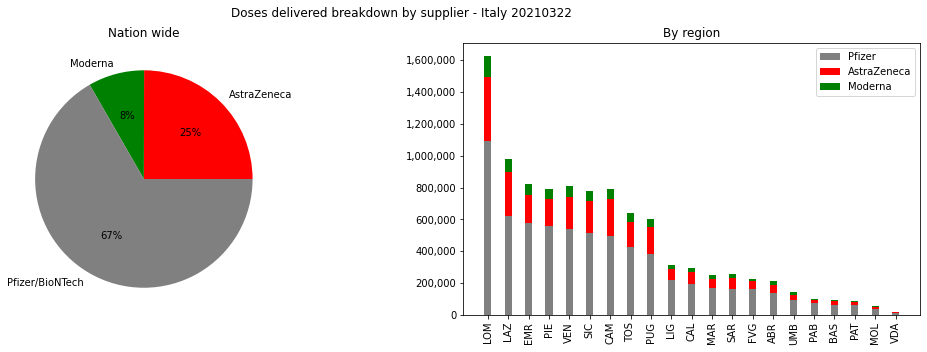

<function matplotlib.pyplot.show>

In [17]:
#Plot Vaccine supplier mix Italy and per region
today=dfVdel.index[-1] #Get last date of relevant data 
d=today.strftime("%Y%m%d")
colors = ["red", "green", "gray"]
fig, axs = plt.subplots(1,2,figsize=(18,5))
warnings.filterwarnings("ignore") # specify to ignore warning messages

#Mix Italy
dfTemp=dfVdel.copy()
dfTemp=dfTemp.groupby(['fornitore'])['numero_dosi'].sum()
#dfTemp.index
#dfTemp.head()
data=dfTemp
labels = dfTemp.index
axs[0].pie(data,labels=labels, autopct='%1.0f%%',colors=colors) #labeldistance=None,pctdistance=1.1,startangle=-15)
axs[0].set_title('Nation wide')

#Mix per region
width = 0.35
dfTemp=pd.pivot_table(dfVdel, values = 'numero_dosi',aggfunc=np.sum, index=['area'], columns = 'fornitore').reset_index()
dfTemp=dfTemp.sort_values(by=['Pfizer/BioNTech'],ascending=False)
pfz=dfTemp['Pfizer/BioNTech']
az=dfTemp['AstraZeneca']
mod=dfTemp['Moderna']
labels=dfTemp['area']
# Heights of bars1 + bars2

bars2 = np.add(pfz,az).tolist()

axs[1].bar(labels,pfz, width,label='Pfizer',color='grey')
axs[1].bar(labels, az,width, bottom=pfz,label='AstraZeneca',color='red')
axs[1].bar(labels, mod, width, bottom=bars2,label='Moderna',color='green')
axs[1].set_xticklabels(labels, rotation = 90)
#axs[1].set_ylabel('Nr.')
axs[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
axs[1].set_title('By region')
axs[1].legend()
fig.suptitle('Doses delivered breakdown by supplier - Italy '+d)

plt.savefig('V'+d+'_ItalyVaccinationDosesSupplier.png')
plt.show()

plt.show

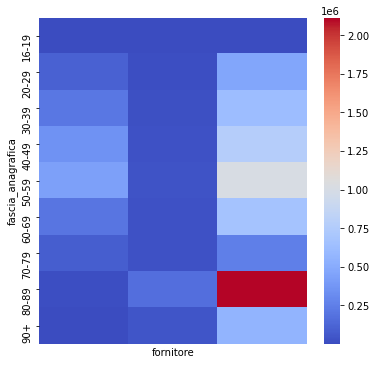

fornitore,AstraZeneca,Moderna,Pfizer/BioNTech
fascia_anagrafica,,,
16-19,780,576,7399
20-29,106885,15098,466839
30-39,208603,21252,623534
40-49,348866,27359,770222
50-59,433709,33759,1010504
60-69,200444,31029,671816
70-79,89588,31164,255889
80-89,13212,166556,2113221
90+,1619,48089,559553


In [18]:
#Pivot Fasce anagrafiche fornitore vaccin
dfAdm=dfVadm.copy()
dfAdm['tot_dosi']= dfAdm['sesso_maschile'] + dfAdm['sesso_femminile']
dfAdm=pd.pivot_table(dfAdm, values = 'tot_dosi',index = ['fascia_anagrafica'],aggfunc=np.sum, columns = 'fornitore')


title_txt1=('Covid19 Cases/100K inhab. per geography \n @'+d+' (data source: Protezione Civile)')

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(dfAdm,xticklabels=False,cmap="coolwarm",ax=ax)
#axes[0].set(title=title_txt1,xlabel="Time")
#plt.savefig(d+'ItalyDashboardHeatmap.png')
plt.show()

dfAdm.head(100)